In [3]:
# Import the cleaned data set
import pandas as pd

file_path = '../data/cleaned_data.csv'
data = pd.read_csv(file_path)
data.head()

,id,stage,accuracy,completeness,innovation,difficulty,n_user_messages,n_internet_resources,time_to_complete_sec,cohort,assignment,llm_experience
0,0,ideation,7,2,1,6.0,0.0,23.0,2075.0,expert,llm_internet,Used a few times
1,0,acquisition,8,6,0,4.0,0.0,22.0,3175.0,expert,llm_internet,Used a few times
2,0,magnification,4,3,0,6.0,0.0,17.0,2158.0,expert,llm_internet,Used a few times
3,0,formulation,3,2,0,2.0,0.0,5.0,1151.0,expert,llm_internet,Used a few times
4,0,release,6,2,0,5.0,0.0,23.0,1816.0,expert,llm_internet,Used a few times


In [16]:
# Import the necessary libraries
from scipy.stats import ttest_ind, mannwhitneyu, barnard_exact
import statsmodels.api as sm
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt


In [41]:
# Get sum counts for various columns given criteria
def get_count(data, compare_column, op, value, cohort_criteria, assignment_criteria):
    # Retrieve the operator function based on the passed operator symbol
    op_func = {
        '>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
        '==': operator.eq,
        '!=': operator.ne
    }[op]
    
    # Build the condition for the main comparison
    condition = op_func(data[compare_column], value)
    
    # Add the fixed conditions for 'cohort' and 'assignment' -- modify if I also need to filter by others
    condition &= (data['cohort'] == cohort_criteria) & (data['assignment'] == assignment_criteria)
    
    # Count the rows that meet all conditions
    return data[condition].shape[0]

In [6]:
# Define statistical analysis helper functions
# These actually perform the statistical tests

def compare_performance(data, metric, group_by='assignment', compare_groups=('llm_internet', 'internet_only'), threshold=0.05):
    # Split the data into groups
    group1 = data[data[group_by] == compare_groups[0]][metric]
    group2 = data[data[group_by] == compare_groups[1]][metric]
    
    # Calculate mean values and sample variances 
    mean1, mean2 = group1.mean(), group2.mean()

    # Perform t-test (Welch's). We don't need a distribution of t-values because we're directly getting the p_value
    t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit', equal_var=False)

    # Perform Mann-Whitney U test
    u_stat, p_value_mw = mannwhitneyu(group1, group2, nan_policy='omit', alternative='two-sided')
    
    return {    
        'mean_with_llms': mean1,
        'mean_without_llms': mean2,
        't_stat': abs(t_stat),
        't_stat_p_value': p_value,
        't_stat_significant': p_value < threshold,
        'u_stat': abs(u_stat),
        'u_stat_p_value': p_value_mw,
        'u_stat_significant': p_value_mw < threshold
    }

In [7]:
# Define statistical analysis main functions
# TODO: understand how I would adapt this function to a different dataset

def compare_performance_across_multiple_segments(data, metrics, group_by='assignment', compare_groups=None, segment_dimensions=None):
    """
    Compare performance across multiple metrics, allowing flexible segmentation along specified dimensions.
    """
    results = []
    
    # Generate a list of unique segment combinations if multiple segment dimensions are specified
    if segment_dimensions and len(segment_dimensions) > 1:
        segment_combinations = data.groupby(segment_dimensions).size().reset_index()[segment_dimensions].values.tolist()
    else:
        segment_combinations = [(segment,) for segment in data[segment_dimensions[0]].unique()] if segment_dimensions else [None]
    
    # Determine the number of comparisons for Bonferroni correction
    total_comparisons = len(metrics) * len(segment_combinations)
    if compare_groups is None:
        compare_groups = data[group_by].unique()  # This might need adjustment based on the data
    total_comparisons *= len(compare_groups) if len(compare_groups) > 2 else 1  # Adjust based on your specific logic
    
    for segment in segment_combinations:
        # Filter data for the current combination of segments
        if segment[0] is not None:
            segment_data = data.copy()
            for dim, val in zip(segment_dimensions, segment):
                segment_data = segment_data[segment_data[dim] == val]
        else:
            segment_data = data
        
        # Automatically determine comparison groups if not specified
        if compare_groups is None:
            compare_groups = segment_data[group_by].unique()
        
        for metric in metrics:
            if len(compare_groups) >= 2:
                # Perform comparison using the first two groups
                comparison_result = compare_performance(segment_data, metric, group_by, compare_groups[:2], threshold = 0.05 / total_comparisons)
                
                # Construct result entry
                result_entry = {
                    'Metric': metric,
                    **comparison_result
                }
                for dim, val in zip(segment_dimensions, segment):
                    result_entry[dim] = val  # Add segment dimension(s) to result
                
                results.append(result_entry)
    
    return pd.DataFrame(results)


In [6]:
data.shape

# TODO: why do my result tables have so few rows?

(500, 12)

# Accuracy

In [18]:
# Checking how this increases accuracy past critical threshold and its statistical significance

'''2x2 table     Above 8 Experts Above 8 Students
LLM + Internet        #                #
Internet Only         #                #
'''

total_exp_llm = get_count(data, 'accuracy', '>=', 8, 'expert', 'llm_internet')
total_student_llm = get_count(data, 'accuracy', '>=', 8, 'student', 'llm_internet')
total_exp_int = get_count(data, 'accuracy', '>=', 8, 'expert', 'internet_only')
total_student_int = get_count(data, 'accuracy', '>=', 8, 'student', 'internet_only')

print(total_exp_llm, total_student_llm, total_exp_int, total_student_int)

# Perform Barnard's exact test -- using the 'greater' alternative hypothesis for first row, the LLM-enabled group
barnard_result = barnard_exact([[total_exp_llm, total_student_llm], [total_exp_int, total_student_int]], alternative='greater')
print(barnard_result)

# Even without adjusting downward for multiple comparisons, this p-value would not be considered statistically significant
# at a common alpha level of <0.05.

37 22 22 17
BarnardExactResult(statistic=0.623827364540935, pvalue=0.3327536422250761)


In [43]:
# Segmenting by stage to get mean uplift
metrics_to_compare = ['accuracy']
segment_dimensions = ['cohort', 'stage']  

accuracy_comparison_results = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)


In [44]:
styled_table = accuracy_comparison_results.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['t_stat_significant', 'u_stat_significant']
)

styled_table


,Metric,mean_with_llms,mean_without_llms,t_stat,t_stat_p_value,t_stat_significant,u_stat,u_stat_p_value,u_stat_significant,cohort,stage
0,accuracy,4.760000,3.520000,1.484205,0.144292,False,381.000000,0.180489,False,expert,acquisition
1,accuracy,5.160000,4.080000,2.210690,0.031914,False,397.000000,0.093333,False,expert,formulation
2,accuracy,7.320000,6.600000,0.790747,0.433050,False,358.500000,0.358446,False,expert,ideation
3,accuracy,4.640000,3.520000,2.547209,0.014603,False,423.500000,0.026551,False,expert,magnification
4,accuracy,4.080000,3.400000,1.278099,0.208393,False,341.000000,0.564350,False,expert,release
5,accuracy,2.160000,3.240000,1.775829,0.083172,False,245.500000,0.166249,False,student,acquisition
6,accuracy,4.000000,3.120000,1.514243,0.136522,False,396.500000,0.098388,False,student,formulation
7,accuracy,7.000000,6.760000,0.255223,0.799642,False,327.500000,0.773876,False,student,ideation
8,accuracy,3.480000,2.520000,1.740761,0.088971,False,385.000000,0.146979,False,student,magnification
9,accuracy,3.360000,3.120000,0.479361,0.633991,False,322.000000,0.854924,False,student,release


In [ ]:
# Segmenting by llm experience
metrics_to_compare = ['accuracy']
segment_dimensions = ['cohort', 'llm_experience']  

accuracy_comparison_results_exp = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment', 
    segment_dimensions=segment_dimensions
)

In [ ]:
styled_table = accuracy_comparison_results_exp.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['t_stat_significant']
)
styled_table


#### Interpreting Our Findings
To interpret the implications of the t-stats (which have no meaning in-of themselves), we need to look at the distributions or grab the p-value. If the p-value is high (>0.05), then regardless of the what the t-value suggests, we do not have statistically significant results. 

A higher t-statistic with a low p-value indicates a statistically significant higher mean for the first group.

In our case:
- Expert accuracy in the formulation and magnification stages were positively impacted
- No other statistically significant findings related to stage
- No other statiscially significant findings related to previous experience

# Completeness

In [45]:
metrics_to_compare = ['completeness']
segment_dimensions = ['cohort', 'stage']  

completeness_comparison_results = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)


In [46]:
styled_table = completeness_comparison_results.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['t_stat_significant']
)
styled_table


,Metric,mean_with_llms,mean_without_llms,t_stat,t_stat_p_value,t_stat_significant,u_stat,u_stat_p_value,u_stat_significant,cohort,stage
0,completeness,5.640000,4.520000,1.688464,0.097934,False,388.500000,0.139070,False,expert,acquisition
1,completeness,3.160000,2.200000,2.673552,0.010771,False,450.500000,0.005916,False,expert,formulation
2,completeness,5.320000,4.640000,1.204594,0.234268,False,374.000000,0.230142,False,expert,ideation
3,completeness,3.360000,2.240000,2.009851,0.050783,False,406.000000,0.066805,False,expert,magnification
4,completeness,2.360000,2.000000,1.160285,0.251680,False,378.000000,0.187130,False,expert,release
5,completeness,4.040000,3.640000,0.741249,0.462156,False,368.500000,0.274329,False,student,acquisition
6,completeness,2.480000,1.720000,1.814330,0.076748,False,388.500000,0.133485,False,student,formulation
7,completeness,4.640000,4.360000,0.598050,0.552784,False,361.500000,0.335317,False,student,ideation
8,completeness,1.600000,1.440000,0.354594,0.724498,False,344.500000,0.524723,False,student,magnification
9,completeness,2.200000,1.760000,1.265260,0.212520,False,370.500000,0.248690,False,student,release


In [242]:
# Segmenting by llm experience
metrics_to_compare = ['completeness']
segment_dimensions = ['cohort', 'llm_experience']  

completeness_comparison_results_exp = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)

In [243]:
styled_table = completeness_comparison_results_exp.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['significant']
)
styled_table


,Metric,mean_with_llms,mean_without_llms,t_stat,p_value,significant,cohort,llm_experience
0,completeness,4.116667,3.314286,1.999045,0.047913,True,expert,Never used
1,completeness,3.700000,2.400000,1.925668,0.079448,False,expert,Use at least once every few weeks
2,completeness,3.942857,2.920000,2.431489,0.017253,True,expert,Used a few times
3,completeness,2.200000,nan,nan,nan,False,student,Never used
4,completeness,2.766667,2.538462,0.666258,0.506494,False,student,Use almost every day
5,completeness,3.450000,2.300000,2.629561,0.010566,True,student,Use at least once every few weeks
6,completeness,2.950000,2.966667,0.028277,0.977565,False,student,Used a few times


#### Interpreting Our Findings
Our findings:
- Expert completeness in the formulation stage was positively impacted
- No other statistically significant findings related to stage
- For experts who never used an LLM, or have only used a few times, completeness was impacted
- For students who use at least every few weeks, completeness was impacted

# Innovation 

In [48]:
metrics_to_compare = ['innovation']
segment_dimensions = ['cohort', 'stage']  

innovation_comparison_results = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)


In [50]:
styled_table = innovation_comparison_results.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['t_stat_significant']
)
styled_table


,Metric,mean_with_llms,mean_without_llms,t_stat,t_stat_p_value,t_stat_significant,u_stat,u_stat_p_value,u_stat_significant,cohort,stage
0,innovation,0.680000,0.440000,0.911465,0.366609,False,373.000000,0.175876,False,expert,acquisition
1,innovation,1.600000,1.160000,0.900149,0.373948,False,332.500000,0.675623,False,expert,formulation
2,innovation,1.600000,1.520000,0.237217,0.813498,False,327.000000,0.778284,False,expert,ideation
3,innovation,0.560000,0.120000,1.942017,0.060911,False,377.000000,0.063436,False,expert,magnification
4,innovation,0.400000,0.320000,0.498703,0.620464,False,320.500000,0.858245,False,expert,release
5,innovation,0.200000,0.240000,0.301511,0.764351,False,290.500000,0.548073,False,student,acquisition
6,innovation,0.720000,0.720000,0.000000,1.000000,False,319.000000,0.887063,False,student,formulation
7,innovation,1.920000,1.320000,1.538293,0.131583,False,368.500000,0.264363,False,student,ideation
8,innovation,0.200000,0.520000,1.380474,0.173836,False,239.000000,0.042322,False,student,magnification
9,innovation,0.360000,0.120000,1.669460,0.103677,False,365.500000,0.143152,False,student,release


In [244]:
# Segmenting by llm experience
metrics_to_compare = ['innovation']
segment_dimensions = ['cohort', 'llm_experience']  

innovation_comparison_results_exp = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)

In [ ]:
styled_table = innovation_comparison_results_exp.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['significant']
)
styled_table


#### Interpreting Our Findings
Our findings:
- No statistically significant findings

# Difficulty

In [231]:
metrics_to_compare = ['difficulty']
segment_dimensions = ['cohort', 'stage']  

difficulty_comparison_results = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)


In [232]:
styled_table = difficulty_comparison_results.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['significant']
)
styled_table

,Metric,mean_with_llms,mean_without_llms,t_stat,p_value,significant,cohort,stage
0,difficulty,6.041667,6.960000,1.259188,0.214461,False,expert,acquisition
1,difficulty,3.875000,4.480000,0.960675,0.341635,False,expert,formulation
2,difficulty,4.458333,4.320000,0.194563,0.846597,False,expert,ideation
3,difficulty,4.041667,3.920000,0.155278,0.877292,False,expert,magnification
4,difficulty,2.916667,2.520000,0.903942,0.370877,False,expert,release
5,difficulty,6.960000,7.040000,0.123462,0.902292,False,student,acquisition
6,difficulty,4.520000,5.640000,1.505652,0.138714,False,student,formulation
7,difficulty,4.720000,5.160000,0.643634,0.522903,False,student,ideation
8,difficulty,3.600000,5.080000,2.231860,0.030439,True,student,magnification
9,difficulty,2.880000,3.080000,0.520814,0.604891,False,student,release


In [246]:
# Segmenting by llm experience
metrics_to_compare = ['difficulty']
segment_dimensions = ['cohort', 'llm_experience']  

difficulty_comparison_results_exp = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)

In [247]:
styled_table = difficulty_comparison_results_exp.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['significant']
)
styled_table


,Metric,mean_with_llms,mean_without_llms,t_stat,p_value,significant,cohort,llm_experience
0,difficulty,4.266667,4.614286,0.745186,0.457527,False,expert,Never used
1,difficulty,4.366667,4.400000,0.054777,0.956944,False,expert,Use at least once every few weeks
2,difficulty,4.166667,4.200000,0.054978,0.956322,False,expert,Used a few times
3,difficulty,5.200000,nan,nan,nan,False,student,Never used
4,difficulty,4.166667,5.138462,2.167870,0.032096,True,student,Use almost every day
5,difficulty,4.375000,5.633333,2.097754,0.039667,True,student,Use at least once every few weeks
6,difficulty,5.800000,4.900000,1.142116,0.259810,False,student,Used a few times


#### Interpreting Our Findings
Our findings:
- Student perception of difficulty in the formulation stage was reduced
- No other statistically significant findings with respect to stage
- Student perception of difficulty was impacted especially if they used almost every day, or at least every few weeks -- this is interesting!

# Time Taken

In [24]:
metrics_to_compare = ['time_to_complete_sec']
segment_dimensions = ['cohort', 'stage']  

time_to_complete_comparison_results = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)

In [25]:
styled_table = time_to_complete_comparison_results.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['t_stat_significant', 'u_stat_significant']
)
styled_table


,Metric,mean_with_llms,mean_without_llms,t_stat,t_stat_p_value,t_stat_significant,u_stat,u_stat_p_value,u_stat_significant,cohort,stage
0,time_to_complete_sec,2835.480000,2930.375000,0.248060,0.805183,False,291.000000,0.865010,False,expert,acquisition
1,time_to_complete_sec,1702.750000,2026.880000,0.916923,0.363868,False,242.000000,0.250144,False,expert,formulation
2,time_to_complete_sec,2378.560000,2035.880000,1.104617,0.275142,False,345.500000,0.528297,False,expert,ideation
3,time_to_complete_sec,2175.160000,2206.040000,0.079191,0.937225,False,304.000000,0.876646,False,expert,magnification
4,time_to_complete_sec,1911.120000,1583.800000,1.204146,0.234532,False,364.000000,0.322396,False,expert,release
5,time_to_complete_sec,2828.360000,3555.760000,1.782344,0.082520,False,252.000000,0.244355,False,student,acquisition
6,time_to_complete_sec,1888.500000,1782.800000,0.439677,0.662201,False,333.000000,0.515692,False,student,formulation
7,time_to_complete_sec,2521.640000,1798.800000,2.651962,0.011054,False,432.000000,0.020944,False,student,ideation
8,time_to_complete_sec,2199.240000,2431.560000,0.587298,0.559845,False,263.000000,0.341737,False,student,magnification
9,time_to_complete_sec,1401.560000,1606.360000,0.681323,0.500206,False,331.500000,0.719624,False,student,release


In [248]:
# Segmenting by llm experience
metrics_to_compare = ['time_to_complete_sec']
segment_dimensions = ['cohort', 'llm_experience']  

time_comparison_results_exp = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)

In [249]:
styled_table = time_comparison_results_exp.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['significant']
)
styled_table


,Metric,mean_with_llms,mean_without_llms,t_stat,p_value,significant,cohort,llm_experience
0,time_to_complete_sec,2404.169492,2187.623188,0.976159,0.330884,False,expert,Never used
1,time_to_complete_sec,1874.133333,1165.400000,1.702154,0.116217,False,expert,Use at least once every few weeks
2,time_to_complete_sec,2151.542857,2197.420000,0.184750,0.853878,False,expert,Used a few times
3,time_to_complete_sec,2458.000000,nan,nan,nan,False,student,Never used
4,time_to_complete_sec,1949.338983,2196.400000,1.102590,0.272461,False,student,Use almost every day
5,time_to_complete_sec,2373.550000,2044.866667,1.020170,0.311932,False,student,Use at least once every few weeks
6,time_to_complete_sec,2342.550000,2509.000000,0.426564,0.671709,False,student,Used a few times


#### Interpreting Our Findings
Our findings:
- Student time to complete in the ideation stage was increased (???)
- No other statistically significant findings with respect to stage or LLM experience.

It does look like a close-to-significant increase in time to complete for experts who have used the LLM at least once every few weeks. It's possible that this is related to scoring higher on some other metrics and is worth exploring more deeply. This assumption seems to qualitatively hold, when looking at the other data.

# Other Random Questions

#### 1. On average, did access to an LLM reduce the number of internet searches that a user made?
Finding: even with the Bonferroni correction, the reduction in the number of internet searches made for both experts and students was significant, only slightly moreso for students than experts.\
For experts, there wasn't as much of a reduction in the magnification and release stages.\
For students, there wasn't as much of a reduction in the ideation stages.

In [26]:
metrics_to_compare = ['n_internet_resources']
segment_dimensions = ['cohort', 'stage']  

internet_search_comparison_results = compare_performance_across_multiple_segments(
    data=data,
    metrics=metrics_to_compare,
    group_by='assignment',
    segment_dimensions=segment_dimensions
)

styled_table = internet_search_comparison_results.style.apply(
    lambda x: ['background-color: lightblue' if v else '' for v in x], 
    subset=['t_stat_significant', 'u_stat_significant']
)
styled_table


,Metric,mean_with_llms,mean_without_llms,t_stat,t_stat_p_value,t_stat_significant,u_stat,u_stat_p_value,u_stat_significant,cohort,stage
0,n_internet_resources,14.400000,27.125000,3.040047,0.003862,True,131.500000,0.000772,True,expert,acquisition
1,n_internet_resources,10.625000,17.600000,1.756732,0.086624,False,123.000000,0.000408,True,expert,formulation
2,n_internet_resources,8.600000,20.080000,4.384235,0.000069,True,123.000000,0.000240,True,expert,ideation
3,n_internet_resources,9.280000,13.600000,1.972130,0.054469,False,224.500000,0.088662,False,expert,magnification
4,n_internet_resources,11.720000,15.840000,1.144857,0.258140,False,222.500000,0.081575,False,expert,release
5,n_internet_resources,10.560000,23.080000,3.211664,0.002625,True,158.500000,0.002866,True,student,acquisition
6,n_internet_resources,6.041667,17.000000,2.846964,0.007380,False,121.500000,0.000359,True,student,formulation
7,n_internet_resources,11.760000,15.080000,1.002965,0.320927,False,250.000000,0.228112,False,student,ideation
8,n_internet_resources,7.600000,17.120000,2.466200,0.017319,False,134.000000,0.000539,True,student,magnification
9,n_internet_resources,5.720000,13.280000,3.322700,0.001922,True,154.500000,0.002199,True,student,release


#### 2. In general, are there correlations with these metrics:
2.a Internet webpages accessed and the number of queries sent, for group that does have access to the internet\
2.b Perceived difficulty, and the number of queries sent

I'll do a qualitative assessment of all of the correlations between all of the metrics by looking at the Pearson's Correlation Coefficients & then plotting.

I'll then do a statistical analysis to analyze my findings.

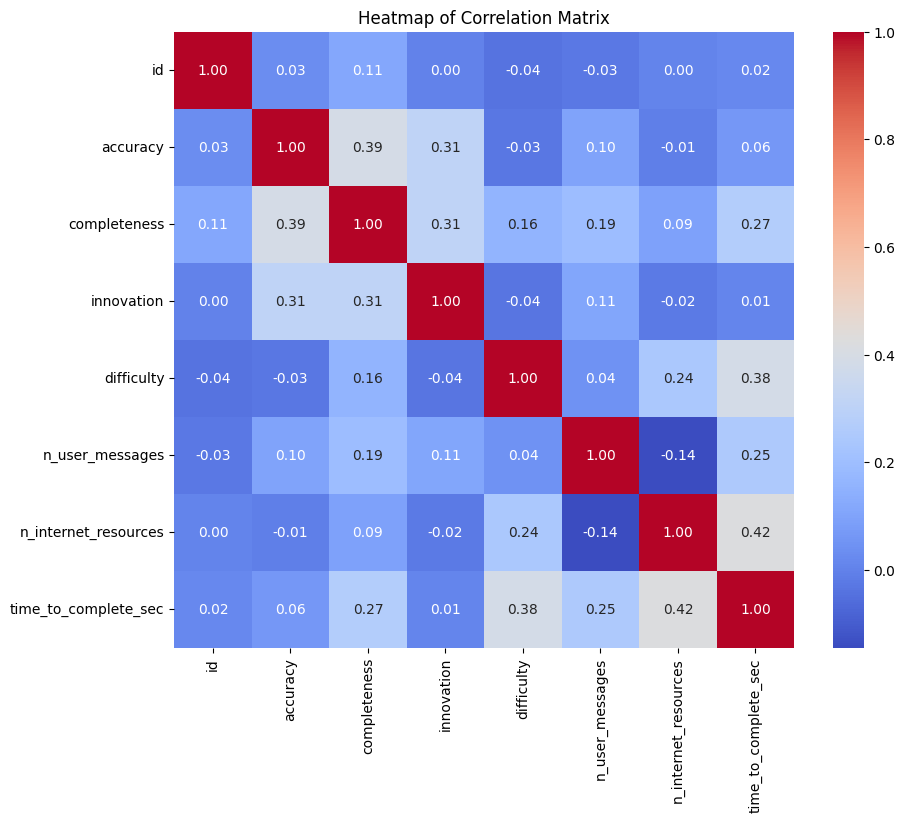

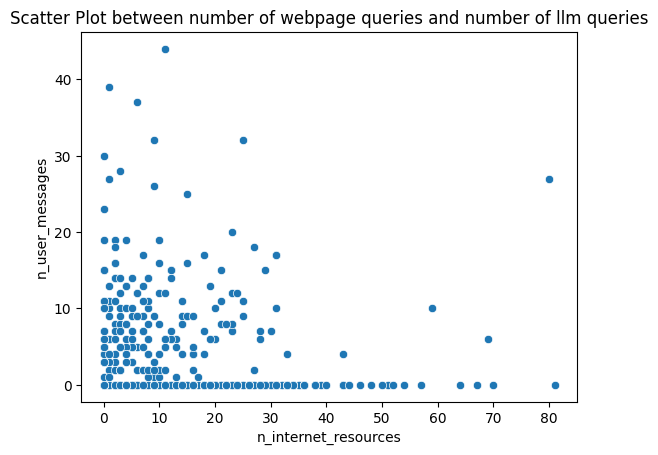

In [40]:
import seaborn as sns

# Calculate Pearson correlation matrix
corr_matrix = data.corr()

# Visualize the correlation matrix of all metrics as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()

# Scatter plot for two variables
sns.scatterplot(x='n_internet_resources', y='n_user_messages', data=data)
plt.title('Scatter Plot between number of webpage queries and number of llm queries')
plt.show()


These results seem to roughly point to the following findings:
- Number of webpage queries, and time to complete in seconds
- Completeness, and accuracy
- Perceived difficulty, and time to complete in seconds
- Small correlation between accuracy, completeness, and innovation

We'll verify the first with more statistical analyses, as practice.

High Queries Group: Participants who had a number of queries above the median level of all tasks.\
Low Queries Group: Participants who had a number of queries at or below the median level.

In [11]:
# Split into two groups
high_queries = data[(data['n_internet_resources'] > data['n_internet_resources'].median()) & (data['assignment'] == 'llm_internet')]['time_to_complete_sec']
low_queries = data[(data['n_internet_resources'] <= data['n_internet_resources'].median()) & (data['assignment'] == 'llm_internet')]['time_to_complete_sec']

# Now perform the t-test
t_stat, p_value = ttest_ind(high_queries, low_queries, nan_policy='omit', equal_var=False)

print("T-test result: t_stat = {}, p_value = {}".format(t_stat, p_value))


T-test result: t_stat = 4.984068206393632, p_value = 1.8543025021784975e-06


This result seems to indicate that is a large correlation between number of internet queries and time to complete (which intuitively makes sense, as you might spend a lot of time browsing web pages vs generating answers on the fly.)

In [19]:
# Run a regression analysis on accuracy, based on several independent variables: 
# This helps to control for confounding variables and understand the relationship between the variables

# Convert the categorical data into dummy variables
binarize_data = pd.get_dummies(data, columns=['cohort', 'llm_experience', 'assignment'], drop_first=True)

# Convert 'accuracy' to numeric and handle infinities; then align 'X' and 'y' before dropping NaNs
y = pd.to_numeric(binarize_data['accuracy'], errors='coerce')
y.replace([np.inf, -np.inf], np.nan, inplace=True)

# Prepare 'X' by selecting numeric types and handling infinities
X = binarize_data.drop(columns=['accuracy'])
X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure 'X' and 'y' indices are aligned before dropping NaNs to avoid KeyError
# Identify rows with NaNs in either 'X' or 'y'
nan_rows = pd.isnull(X).any(axis=1) | pd.isnull(y)
X = X[~nan_rows]
y = y[~nan_rows]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit()

# Printing the summary
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     10.54
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           1.26e-18
Time:                        12:10:55   Log-Likelihood:                -1136.0
No. Observations:                 492   AIC:                             2298.
Df Residuals:                     479   BIC:                             2353.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

The F-Stat is relatively high, and the probability relatively low, suggesting that the results are statistically significant.

Based on the coefficients table, innovation, completeness seem to be strong predictors of accuracy. All other variables seem to be non-significant.